This notebook explores historical 1-bedroom median rents in major U.S. cities using Zillow’s public dataset. I wanted to understand how affordability has shifted over time, and this notebook is the first step: loading and transforming raw rent data.

## 1. Gather data

First I'm going to download the raw data for the Zillow Observed Rent Index for the cities I'm interested in. I'm looking for city rent data over time, so I want something longitudinal.

![Alt text](image1.png)

In [1]:
%pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read in the CSV file
df = pd.read_csv('City_zori_uc_sfrcondomfr_sm_month.csv')

# Display basic information about the dataframe
print("DataFrame Info:")
print(df.info())

# Show the first few rows
print("\nFirst few rows:")
print(df.head())

# Display column names
print("\nColumn names:")
print(df.columns.tolist())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Columns: 130 entries, RegionID to 2025-02-28
dtypes: float64(122), int64(2), object(6)
memory usage: 3.3+ MB
None

First few rows:
   RegionID  SizeRank   RegionName RegionType StateName State  \
0      6181         0     New York       city        NY    NY   
1     12447         1  Los Angeles       city        CA    CA   
2     39051         2      Houston       city        TX    TX   
3     17426         3      Chicago       city        IL    IL   
4      6915         4  San Antonio       city        TX    TX   

                                   Metro          CountyName   2015-01-31  \
0  New York-Newark-Jersey City, NY-NJ-PA       Queens County  2519.633872   
1     Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  1829.491393   
2   Houston-The Woodlands-Sugar Land, TX       Harris County  1192.772833   
3     Chicago-Naperville-Elgin, IL-IN-WI         Cook County  1525.898035   
4  

So we can tell that the data is
- One row per city (perfect)
- Includes the metro area, state, county etc (not really  necessary)
- And the observed rent (the mean of the 35th to 65th percentile, per Zillow).

Great! 

Next I want to isolate only the cities I particularly care about for this analysis. For this purpose, that's cities I've lived in:
- Dallas, TX
- Cambridge, MA
- Brooklyn, NY
- Oakland, CA
- San Francisco, CA

... and cities where I'm curious about tracking their affordability over time, since I'm curious how the pandemic and remote work boom has affected them:
- Portland, OR
- Seattle, WA
- Miami, FL

Let's isolate that data now. I have a feeling the data won't be as neatly set up as I hope, but first pass:



In [4]:
# Filter for specific cities of interest
cities_of_interest = ['New York','Brooklyn', 'Dallas', 'Cambridge', 'Oakland', 'San Francisco', 'Portland', 'Seattle', 'Miami']
filtered_df = df[df['RegionName'].isin(cities_of_interest)]

# Display the filtered dataframe
print("Filtered DataFrame:")
print(filtered_df)


Filtered DataFrame:
      RegionID  SizeRank     RegionName RegionType StateName State  \
0         6181         0       New York       city        NY    NY   
9        38128         9         Dallas       city        TX    TX   
17       20330        17  San Francisco       city        CA    CA   
20       12700        20          Miami       city        FL    FL   
24       16037        24        Seattle       city        WA    WA   
25       13373        25       Portland       city        OR    OR   
51       13072        51        Oakland       city        CA    CA   
355       3934       360      Cambridge       city        MA    MA   
521      24307       526         Dallas       city        GA    GA   
795      40415       808       Portland       city        ME    ME   
2191     51636      2699         Dallas       city        OR    OR   
2591      6584      3611       Portland       city        TX    TX   
2969     13076      5333        Oakland       city        TN    TN   


A few findings:
- A few extra cities are included in the data that need to be excluded.
- NYC doesn't split out into the county level data that includes Brooklyn. (Right?)

Let's investigate:

In [5]:
# Look at all regions in the NYC metro area and see if you can narrow down.
nyc_regions = df[df['Metro'] == 'New York-Newark-Jersey City, NY-NJ-PA'][['RegionName', 'State', 'CountyName']]
nyc=nyc_regions[nyc_regions['CountyName'].isin(['New York County', 'Kings County', 'Queens County', 'Bronx County', 'Richmond County'])]
print("\nNYC metro area cities in the dataset:")
print(nyc)


NYC metro area cities in the dataset:
  RegionName State     CountyName
0   New York    NY  Queens County


Bummer. OK, we'll leave that in. Now removing the extra data we don't need, and looking at the result:

In [6]:

# Also, create some states we're not interested in and filter the dataset.
states_to_exclude = ['TN', 'GA', 'ME']
counties_to_exclude = ['San Patricio County'] # removing the extra corpus christi data
filtered_df = filtered_df[~filtered_df['State'].isin(states_to_exclude)]
filtered_df = filtered_df[~filtered_df['CountyName'].isin(counties_to_exclude)]

# Display the filtered dataframe
print("\nFiltered DataFrame:")
print(filtered_df)


Filtered DataFrame:
      RegionID  SizeRank     RegionName RegionType StateName State  \
0         6181         0       New York       city        NY    NY   
9        38128         9         Dallas       city        TX    TX   
17       20330        17  San Francisco       city        CA    CA   
20       12700        20          Miami       city        FL    FL   
24       16037        24        Seattle       city        WA    WA   
25       13373        25       Portland       city        OR    OR   
51       13072        51        Oakland       city        CA    CA   
355       3934       360      Cambridge       city        MA    MA   
2191     51636      2699         Dallas       city        OR    OR   

                                        Metro            CountyName  \
0       New York-Newark-Jersey City, NY-NJ-PA         Queens County   
9             Dallas-Fort Worth-Arlington, TX         Dallas County   
17         San Francisco-Oakland-Berkeley, CA  San Francisco Coun

Perfect. Next we need to `melt` the data-- get one row per observation (long) rather than the current format (wide), which annoyingly has months in the coolumns. In this case, we want to:
- Keep certain columns as identifiers (RegionName, State, Metro, etc.)
- Melt all the date columns into two new columns:
-- One for the date
-- One for the rent value


In [7]:
# Keep these columns as identifiers
id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
           'State', 'Metro', 'CountyName']

# Melt the dataframe
melted_df = pd.melt(filtered_df, 
                   id_vars=id_vars,
                   var_name='Date',  # This will be the new column for dates
                   value_name='Rent')  # This will be the new column for rent values

# Let's take a look.
melted_df.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Date,Rent
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2015-01-31,2519.633872
1,38128,9,Dallas,city,TX,TX,"Dallas-Fort Worth-Arlington, TX",Dallas County,2015-01-31,1074.757370
2,20330,17,San Francisco,city,CA,CA,"San Francisco-Oakland-Berkeley, CA",San Francisco County,2015-01-31,2991.486666
3,12700,20,Miami,city,FL,FL,"Miami-Fort Lauderdale-Pompano Beach, FL",Miami-Dade County,2015-01-31,1696.931325
4,16037,24,Seattle,city,WA,WA,"Seattle-Tacoma-Bellevue, WA",King County,2015-01-31,1543.150935
5,13373,25,Portland,city,OR,OR,"Portland-Vancouver-Hillsboro, OR-WA",Multnomah County,2015-01-31,1181.526835
6,13072,51,Oakland,city,CA,CA,"San Francisco-Oakland-Berkeley, CA",Alameda County,2015-01-31,1786.294639
7,3934,360,Cambridge,city,MA,MA,"Boston-Cambridge-Newton, MA-NH",Middlesex County,2015-01-31,2353.489078
8,51636,2699,Dallas,city,OR,OR,"Salem, OR",Polk County,2015-01-31,NaN
9,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2015-02-28,2532.526220


Looking good! The data looks like it's in the right format and correct timeframe (10 years or so). Now I'd like to see it graphed simply. For this I'll use `seaborn` since it's easier syntax and prettier than just `matplotlib`.

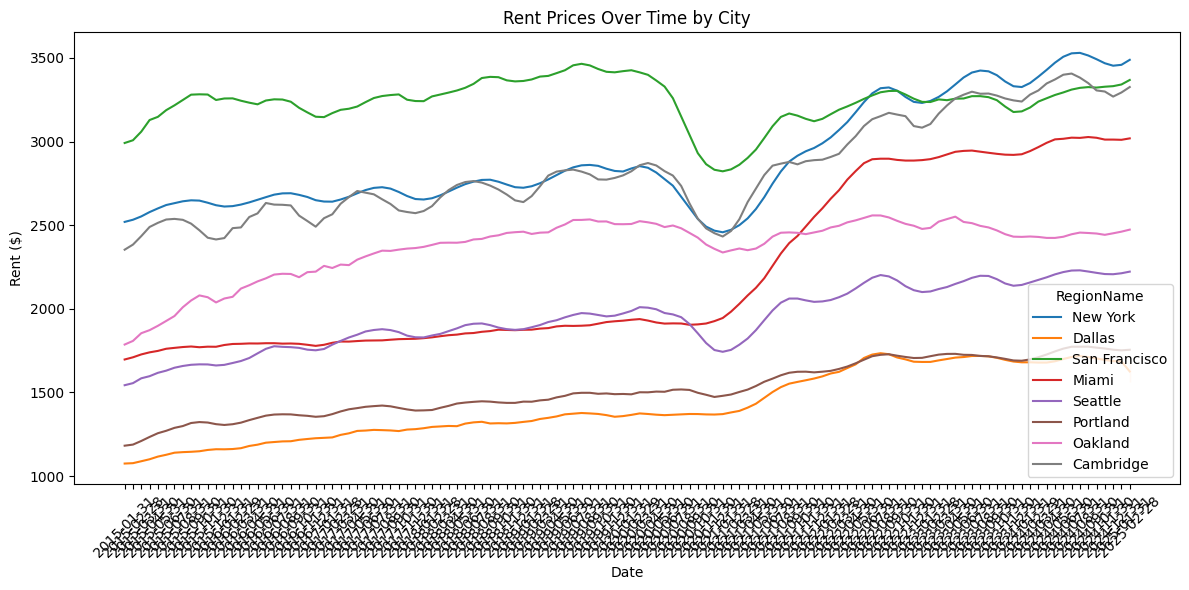

In [8]:
# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Date', y='Rent', hue='RegionName')

# Customize the plot
plt.title('Rent Prices Over Time by City')
plt.xticks(rotation=45)
plt.ylabel('Rent ($)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


Great -- and I can already start to see some of the trends that I want to see. But clearly the viz needs a lot of cleanup.

NameError: name 'YearLocator' is not defined

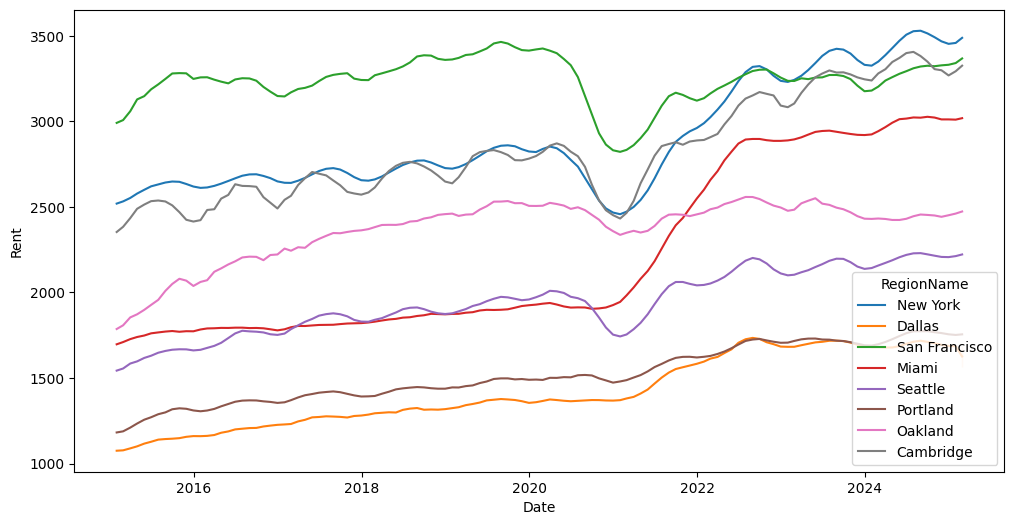

In [9]:
# Convert Date column to datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Date', y='Rent', hue='RegionName')

# Format x-axis to show only yearly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())  # Show ticks every year
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format as just the year

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add title and adjust layout
plt.title('Rent Over Time by City')
plt.tight_layout()

# Show the plot
plt.show()